# Inspect Trained Model

    Code and visualizations to test, debug, and evaluate the pre-trained Mask R-CNN model.

In [53]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples import particles

%matplotlib inline 


## Configurations

In [54]:
config = particles.ParticlesConfig()
ROOT_DIR = os.getcwd()
PARTICLE_DIR = os.path.join(ROOT_DIR, "data/")

In [55]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [56]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
#DEVICE = "/gpu:0"

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [57]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [59]:
# Load validation dataset
dataset = particles.ParticlesDataset()
dataset.load_particles(PARTICLE_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 63
Classes: ['BG', 'particles']


## Load Model

In [60]:
# Set path to particle weights file
# Create model in inference mode
MODEL_DIR = os.path.join(ROOT_DIR, "log/")
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
# Or, load the last model you trained
#weights_path = model.find_last()
# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/hijizhou/LIBNet/releases
PARTICLE_WEIGHTS_PATH = os.path.join(ROOT_DIR, "model/mask_rcnn_particle.h5")  # TODO: update this path

# Load weights
print("Loading weights ", PARTICLE_WEIGHTS_PATH)
model.load_weights(PARTICLE_WEIGHTS_PATH, by_name=True)

Loading weights  /home/lijz/LIBNet/model/mask_rcnn_particle.h5


## Run Detection

image ID: particles.xz0800.jpg (16) /home/lijz/LIBNet/data/val/xz0800.jpg
Original image shape:  [ 492 1985    3]
(1024, 1024, 3)
image_id:  16
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (69,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (69, 4)               min:    2.00000  max: 1021.00000  int32
gt_mask                  shape: (1024, 1024, 69)      min:    0.00000  max:    1.00000  bool
AP: 0.9832104077296596
AP @0.50:	 0.983
AP @0.55:	 0.983
AP @0.60:	 0.983
AP @0.65:	 0.983
AP @0.70:	 0.983
AP @0.75:	 0.947
AP @0.80:	 0.877
AP @0.85:	 0.611
AP @0.90:	 0.134

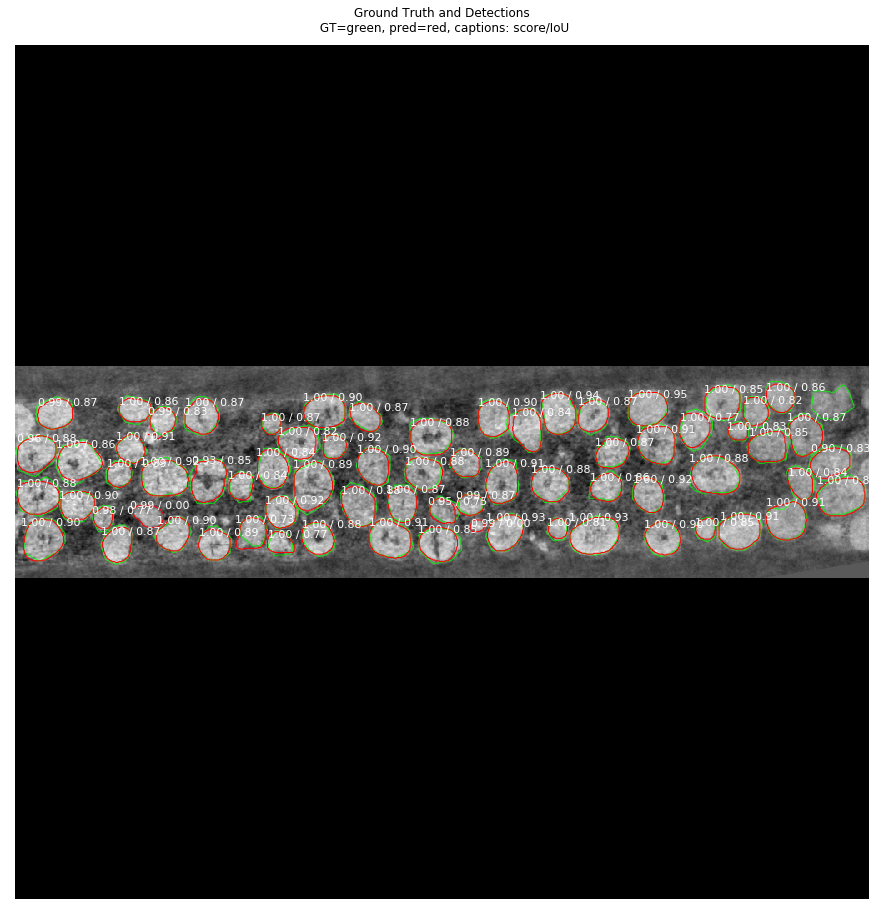

In [112]:
#image_id = random.choice(dataset.image_ids)
#image_id = 53
#image_id = 12
#image_id=24
#image_id = 70
#image_id = 38 ##AP=1
#image_id = 29 ##AP=1
#image_id = 61 ##AP=1
image_id = 16 ##AP=0.983
#image_id=49  ##few particles
#image_id=69 ##missed one
#image_id = 100
#image_id = 62

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

print(image.shape)
print("image_id: ", image_id)
# Run object detection
#results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
results = model.detect([image], verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
print("AP:", AP)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.1, score_threshold=0.1)

## Batch detection and save the results

In [137]:
save_dir= os.path.join(ROOT_DIR, "data/val_output")
gt_dir= os.path.join(ROOT_DIR, "data/val_gt")
ori_dir= os.path.join(ROOT_DIR, "data/val_ori")

BATCH = False

if BATCH:

    for image_id in dataset.image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        info = dataset.image_info[image_id]
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        ax = get_ax(1)
        print(image_id)
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        mask = r['masks']
        MASK = np.zeros(mask[:,:,0].shape).astype(np.uint8)
        for c in range(len(mask[0,0])):
            MASK = MASK + mask[:, :, c]*c*1.0
        
        # Obtained mask
        masked_image = Image.fromarray(MASK)
        masked_image.save(os.path.join(save_dir, '%s.tif' % (image_id)))
        
        # Original image
        masked_image = Image.fromarray(image)
        masked_image.save(os.path.join(ori_dir, '%s.tif' % (image_id)))
        
        # Ground truth mask
        MASK = np.zeros(gt_mask[:,:,0].shape).astype(np.uint8)
        for c in range(len(gt_mask[0,0])):
            MASK = MASK + gt_mask[:, :, c]*c*1.0
        masked_image = Image.fromarray(MASK)
        masked_image.save(os.path.join(gt_dir, '%s.tif' % (image_id)))

## Precision recall

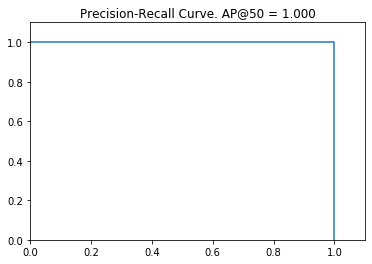

In [42]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)


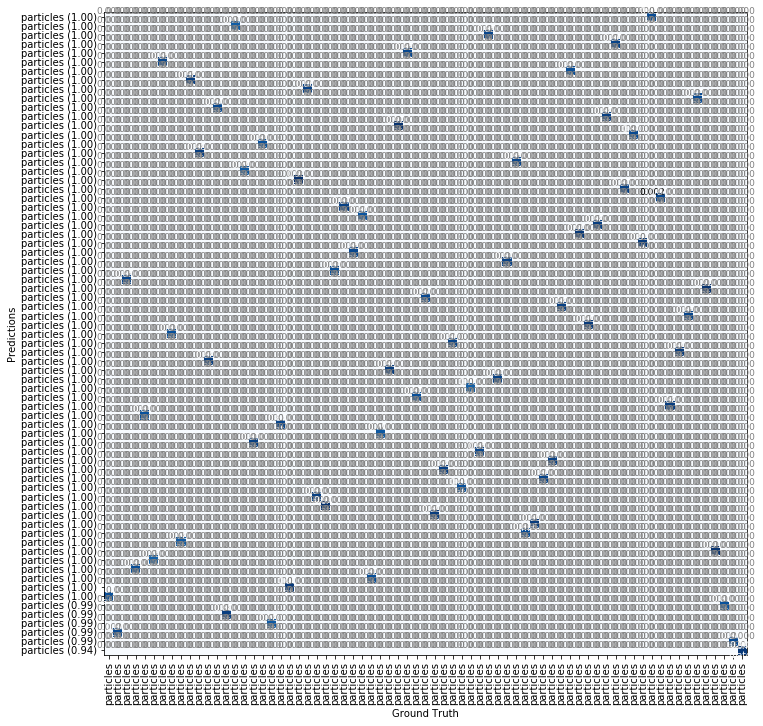

In [44]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)


In [62]:
# Compute VOC-style Average Precision
def compute_batch_eval(image_ids):
    APs = []
    Precisions = []
    Recalls = []
    Overlaps = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        #print(AP, ' + ', precisions, ' + ',recalls, ' + ',overlaps )
        APs.append(AP)
        
        tmp = recalls<0.8
        Precisions.append(precisions.mean())
        Recalls.append(np.sum(tmp) / len(recalls))
        Overlaps.append(overlaps.max())
    
    
    #print("Precisions @ IoU=50: ", np.mean(Precisions))
    #print("Recalls @ IoU=50: ", np.mean(Recalls))
    #print("Overlaps @ IoU=50: ", np.mean(Overlaps))
    #print("mAP @ IoU=50: ", np.mean(APs))
    
    return APs, Precisions, Recalls, Overlaps

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs, Precisions, Recalls, Overlaps = compute_batch_eval(image_ids)


In [64]:
print("Precisions : ", np.mean(Precisions))
print("Recalls @ IoU=50: ", np.mean(Recalls))
print("Overlaps @ IoU=50: ", np.mean(Overlaps))
print("mAP @ IoU=50: ", np.mean(APs))

Precisions :  0.9701004679307446
Recalls @ IoU=50:  0.7924704115773714
Overlaps @ IoU=50:  0.9405235
mAP @ IoU=50:  0.9481978349590843


In [65]:
print("Precisions : ", np.std(Precisions))
print("Recalls @ IoU=50: ", np.std(Recalls))
print("Overlaps @ IoU=50: ", np.std(Overlaps))
print("mAP @ IoU=50: ", np.std(APs))

Precisions :  0.033097319631645146
Recalls @ IoU=50:  0.03133279535346319
Overlaps @ IoU=50:  0.014478624
mAP @ IoU=50:  0.06695279936658108


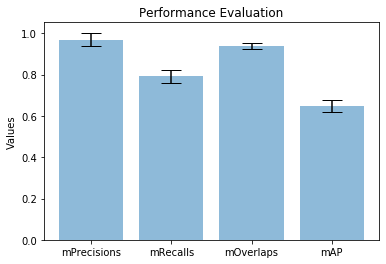

In [138]:
objects = ('mPrecisions', 'mRecalls', 'mOverlaps', 'mAP')
y_pos = np.arange(len(objects))
performance = [np.mean(Precisions), np.mean(Recalls), np.mean(Overlaps), np.mean(APs)]
standard = [np.std(Precisions), np.std(Recalls), np.std(Overlaps), np.std(APs)]


plt.bar(y_pos, performance, yerr=standard,align='center', alpha=0.5,capsize =10)
plt.xticks(y_pos, objects)
plt.ylabel('Values')
plt.title('Performance Evaluation')


plt.savefig('assets/performance_mask_rcnn.png', dpi=500)


plt.show()

In [67]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 5
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [ 492 1324    3]   AP: 0.62
  1 [ 492 1324    3]   AP: 0.65
  2 [ 492 1324    3]   AP: 0.62
  3 [ 492 1324    3]   AP: 0.70
  4 [ 492 1324    3]   AP: 0.65
Mean AP overa 5 images: 0.6489


input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   18.83215  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80073  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   58.07735  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -10.83372  max:   31.86010  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


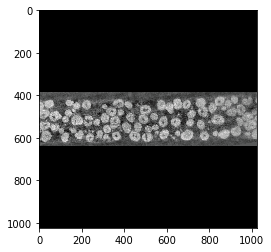

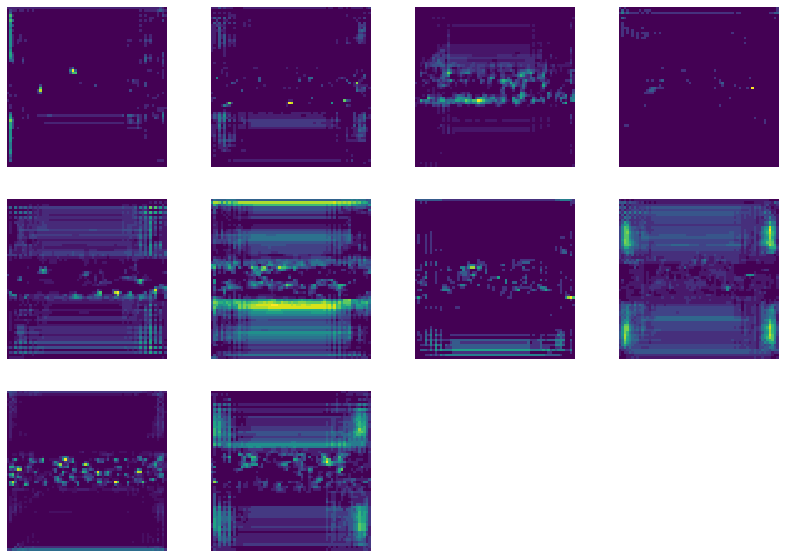

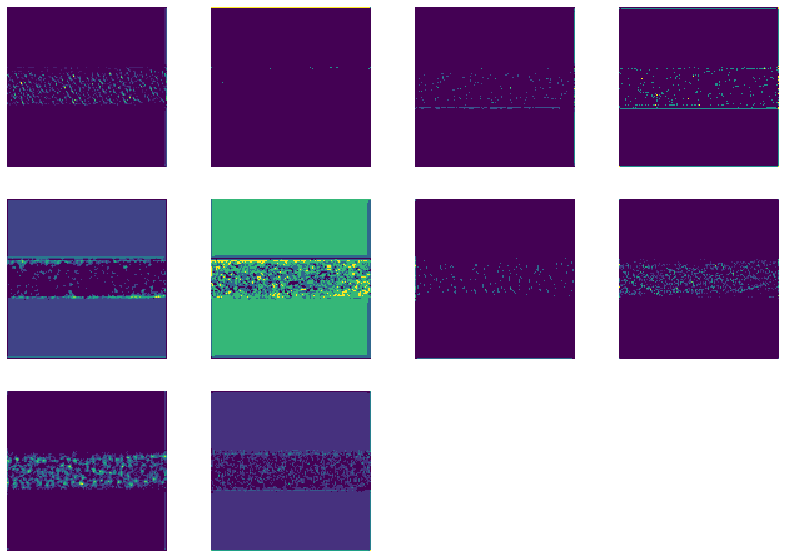

In [68]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

# Backbone feature map
#display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)
display_images(np.transpose(activations["res4w_out"][0,:,:,:10], [2, 0, 1]))
display_images(np.transpose(activations["res3c_out"][0,:,:,:10], [2, 0, 1]))



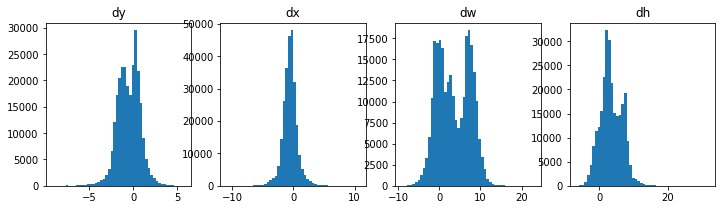

In [69]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

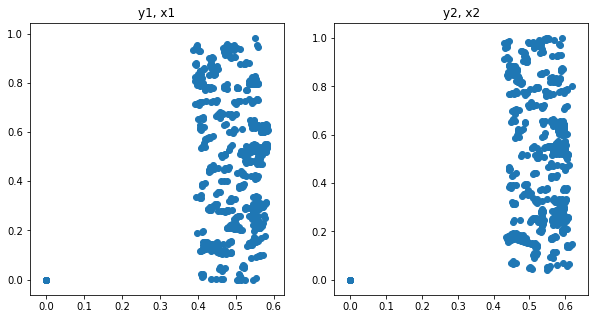

In [70]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [71]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -3.53553  max:    3.09254  float64
positive_anchors         shape: (128, 4)              min:    0.00000  max: 1016.00000  float64
negative_anchors         shape: (128, 4)              min:  -64.00000  max: 1098.50967  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (128, 4)              min:    2.00000  max: 1007.00000  float32


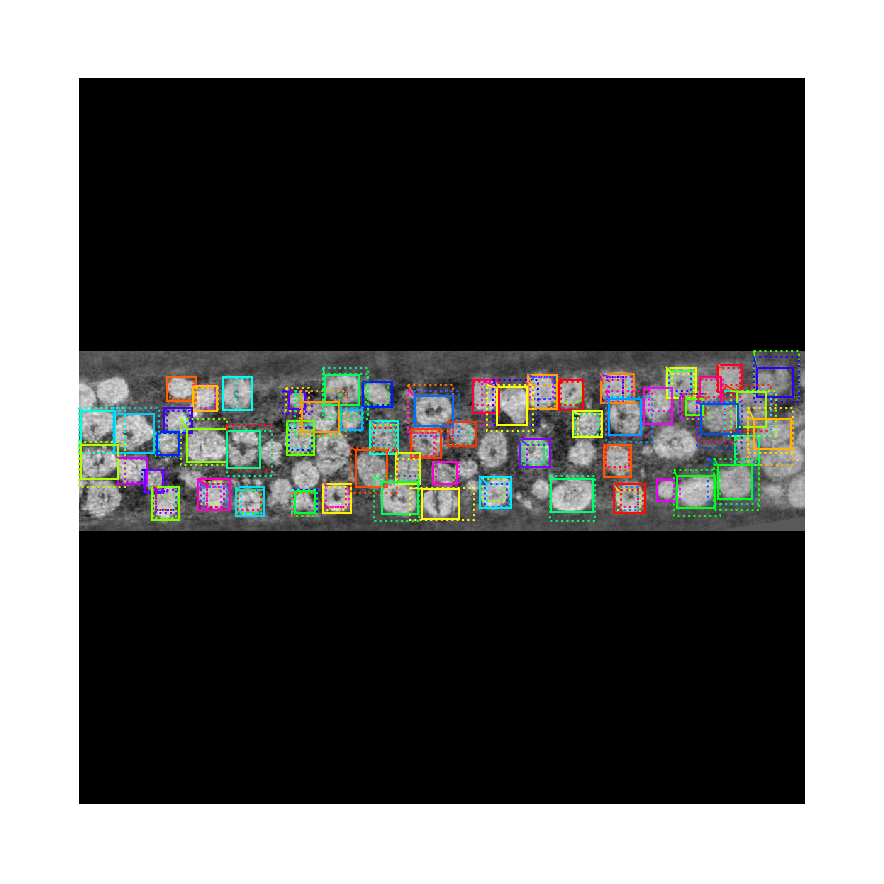

In [72]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [73]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.02860  max:    1.02078  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.00541  max:    1.00239  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (707,)                min:    0.00000  max: 5994.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


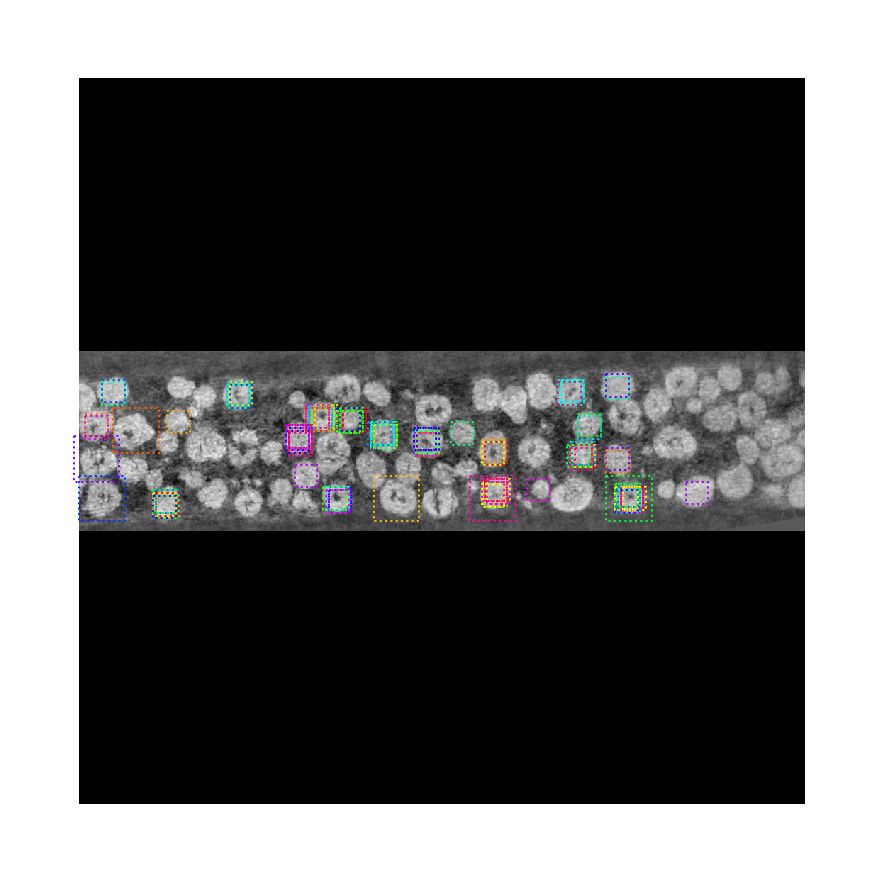

In [74]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

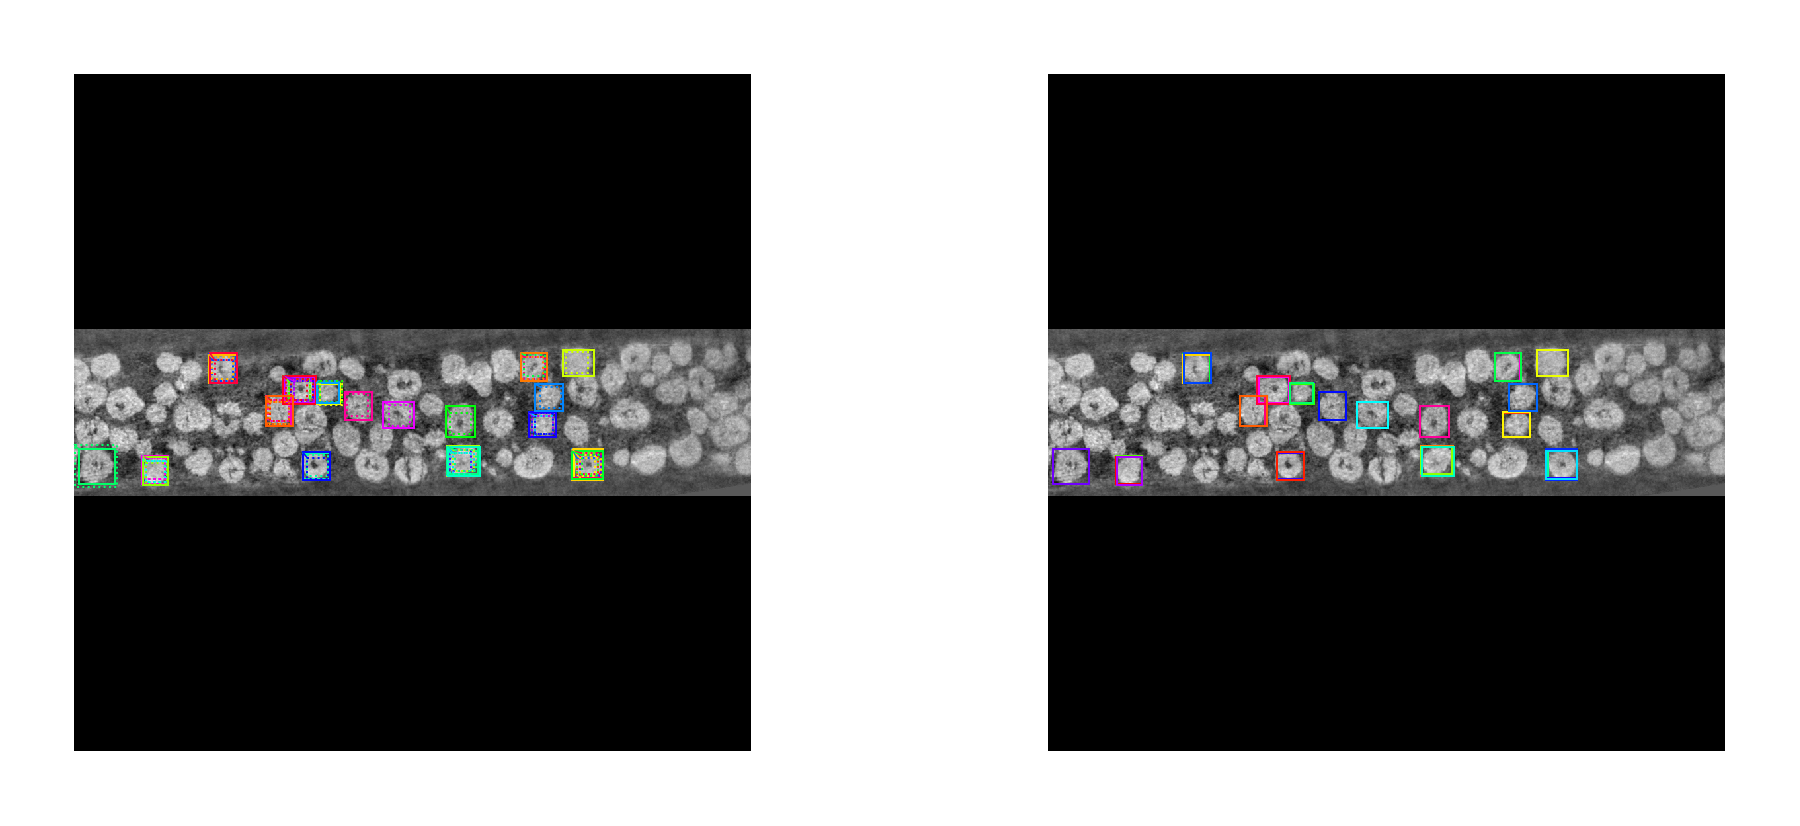

In [75]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

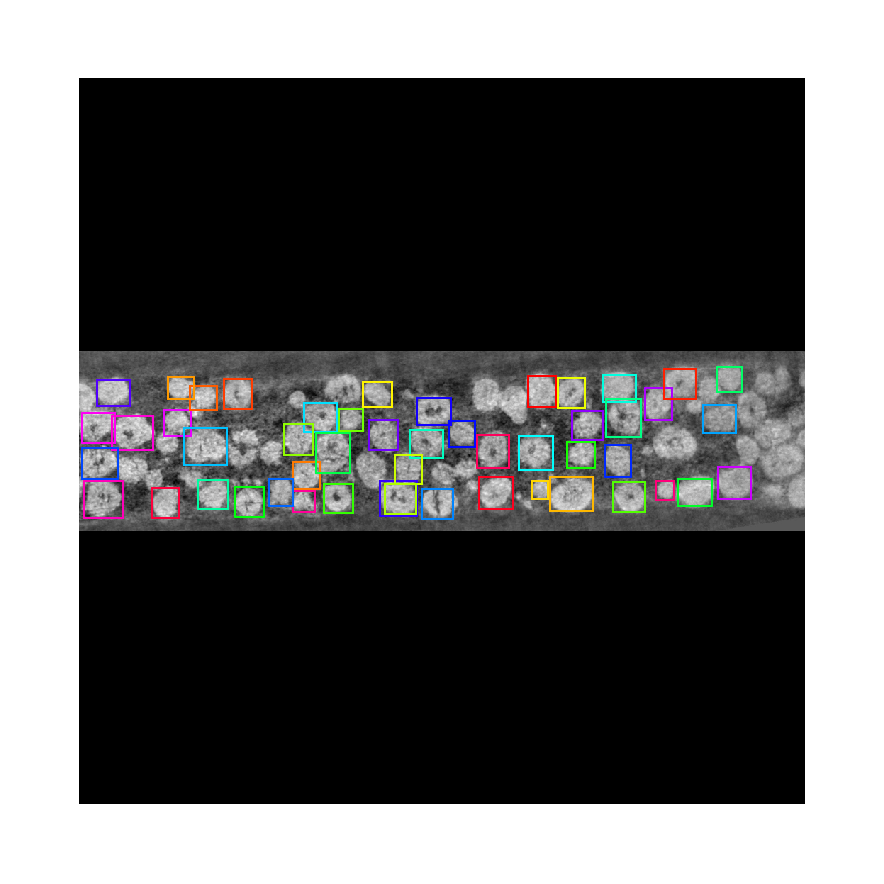

In [76]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

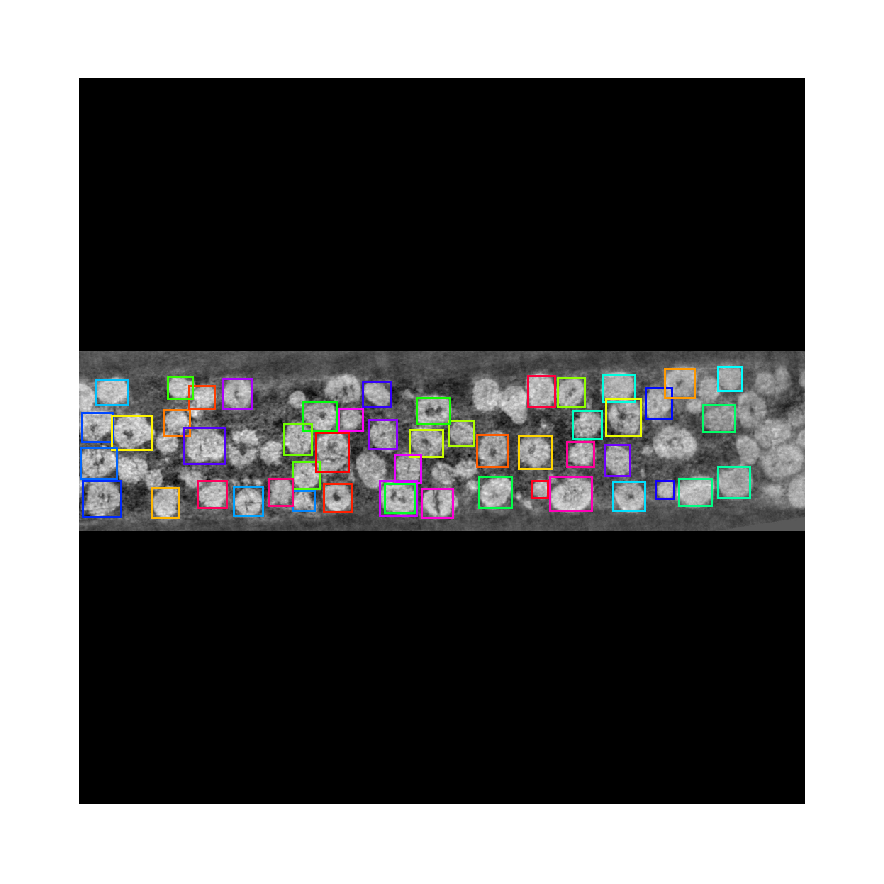

In [77]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [78]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -4.17549  max:    4.66570  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


70 detections: ['particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles']


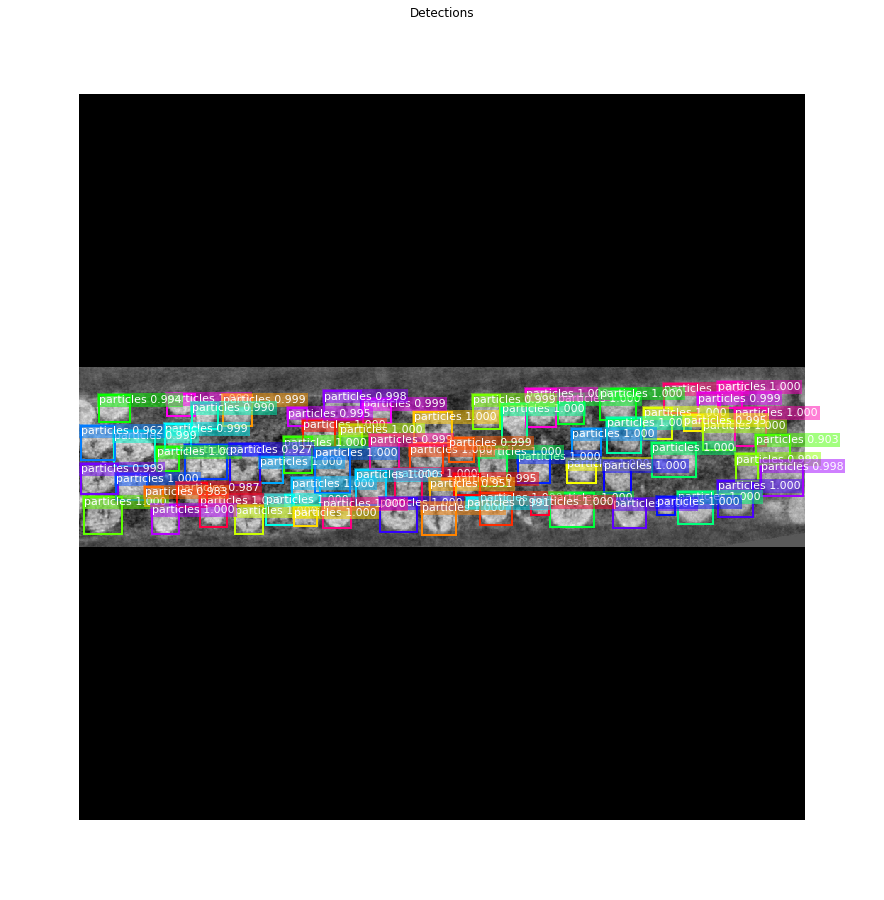

In [79]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [80]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

707 Valid proposals out of 1000
319 Positive ROIs
[('BG', 681), ('particles', 319)]


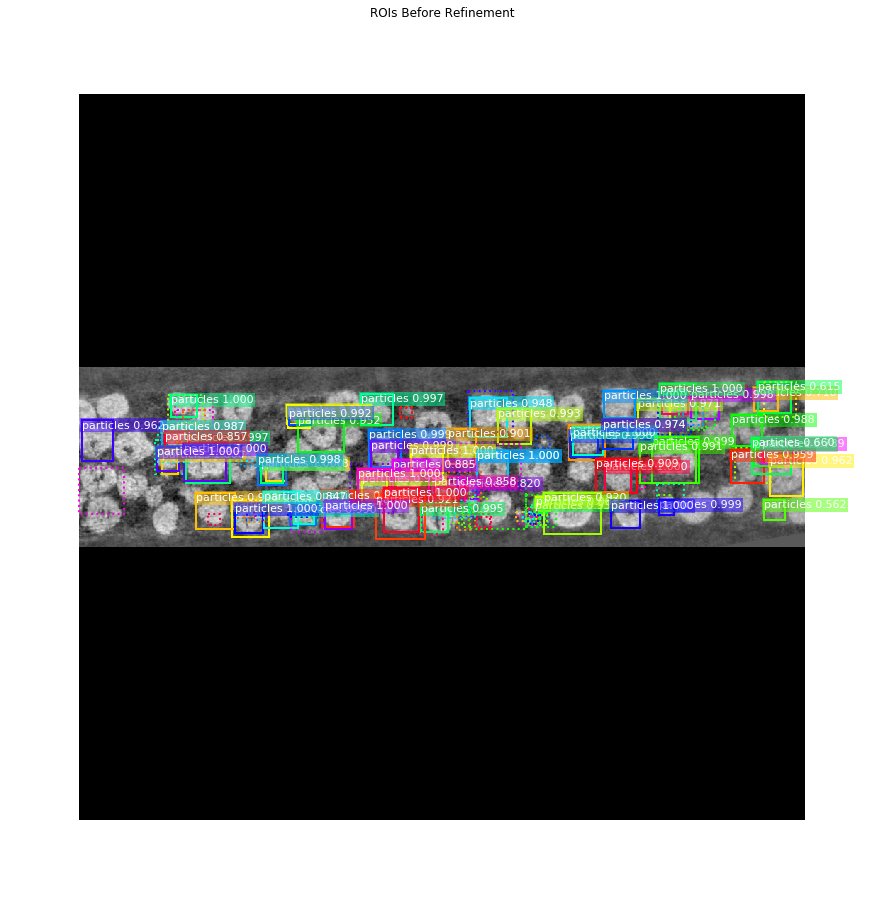

In [81]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.46418  max:    3.56087  float32
refined_proposals        shape: (1000, 4)             min:    0.00000  max: 1025.00000  int32


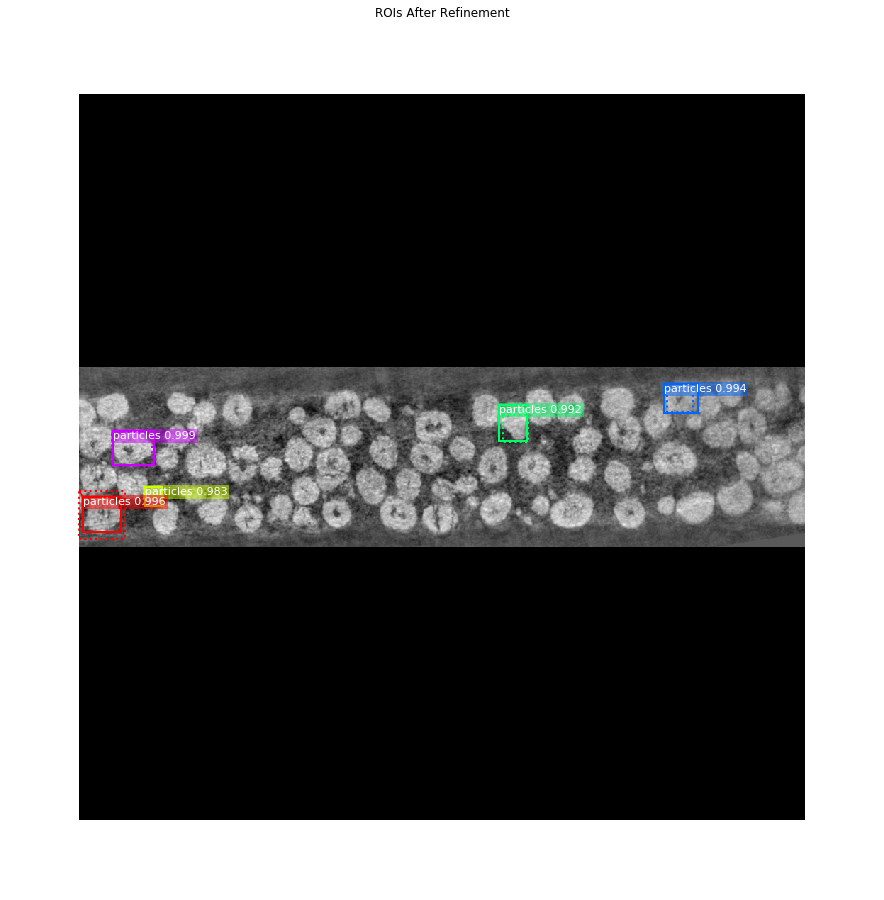

In [82]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [83]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 319 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  58  59  60  61  62  63  64  65  66  67  68  70  71  72  75
  76  77  78  79  80  81  82  84  87  88  89  92  93  94  95  96  97  98
  99 103 104 105 108 109 110 111 112 113 114 115 117 119 120 121 122 123
 124 125 127 130 131 132 134 136 137 139 143 144 146 147 148 150 152 153
 154 156 157 160 161 162 164 166 167 168 169 170 171 172 174 176 177 178
 180 181 182 184 185 188 189 191 196 200 202 203 206 210 212 218 219 220
 221 223 224 226 227 229 231 232 233 234 235 238 241 244 245 248 250 251
 253 254 256 257 259 260 262 264 270 271 272 279 286 287 289 291 292 295
 296 299 301 304 306 312 314 315 319 321 323 327 330 333 334 335 337 339
 340 343 344 348 350 351 353 355 356 357 360 361 364 368 372 373 376 379
 381 385 395 396 402 406 409 4

In [84]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 262:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  58  59  60  61  62  64  65  66  67  68  70  71  72  75  77
  79  80  81  82  87  89  92  93  94  95  96  97  98  99 103 104 105 110
 111 112 113 114 115 117 120 122 123 127 130 131 132 134 136 137 139 147
 148 150 152 154 156 157 160 161 164 166 167 168 170 172 174 176 177 178
 180 181 182 184 185 189 196 200 206 212 218 220 221 226 227 231 232 233
 234 235 238 241 244 245 248 250 251 253 254 256 257 259 260 262 270 271
 272 279 287 291 292 295 296 299 301 306 312 315 319 321 323 327 330 334
 335 337 340 343 344 348 350 353 356 357 360 361 364 368 372 373 379 381
 385 395 406 409 414 419 420 423 424 428 429 437 440 446 448 449 450 470
 475 478 483 485 489 492 493 496 497 498 502 507 513 520 523 526 531 536
 540 5

#### Per-Class Non-Max Suppression

In [85]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

particles             : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  58  59  60  61  62  64  65  66  67  68  70  71  72  75  77
  79  80  81  82  87  89  92  93  94  95  96  97  98  99 103 104 105 110
 111 112 113 114 115 117 120 122 123 127 130 131 132 134 136 137 139 147
 148 150 152 154 156 157 160 161 164 166 167 168 170 172 174 176 177 178
 180 181 182 184 185 189 196 200 206 212 218 220 221 226 227 231 232 233
 234 235 238 241 244 245 248 250 251 253 254 256 257 259 260 262 270 271
 272 279 287 291 292 295 296 299 301 306 312 315 319 321 323 327 330 334
 335 337 340 343 344 348 350 353 356 357 360 361 364 368 372 373 379 381
 385 395 406 409 414 419 420 423 424 428 429 437 440 446 448 449 450 470
 475 478 483 485 489 492 493 496 497 498 502 507 513 520 523 526 531 536
 540 543 546 551 559 562 57

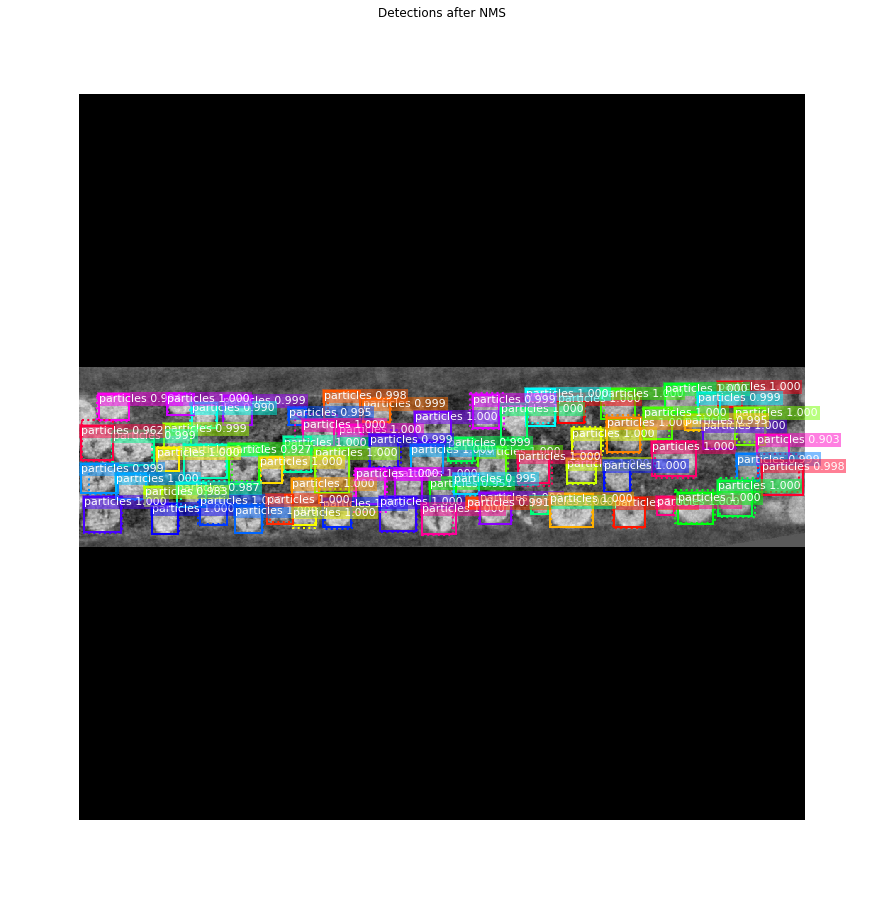

In [86]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

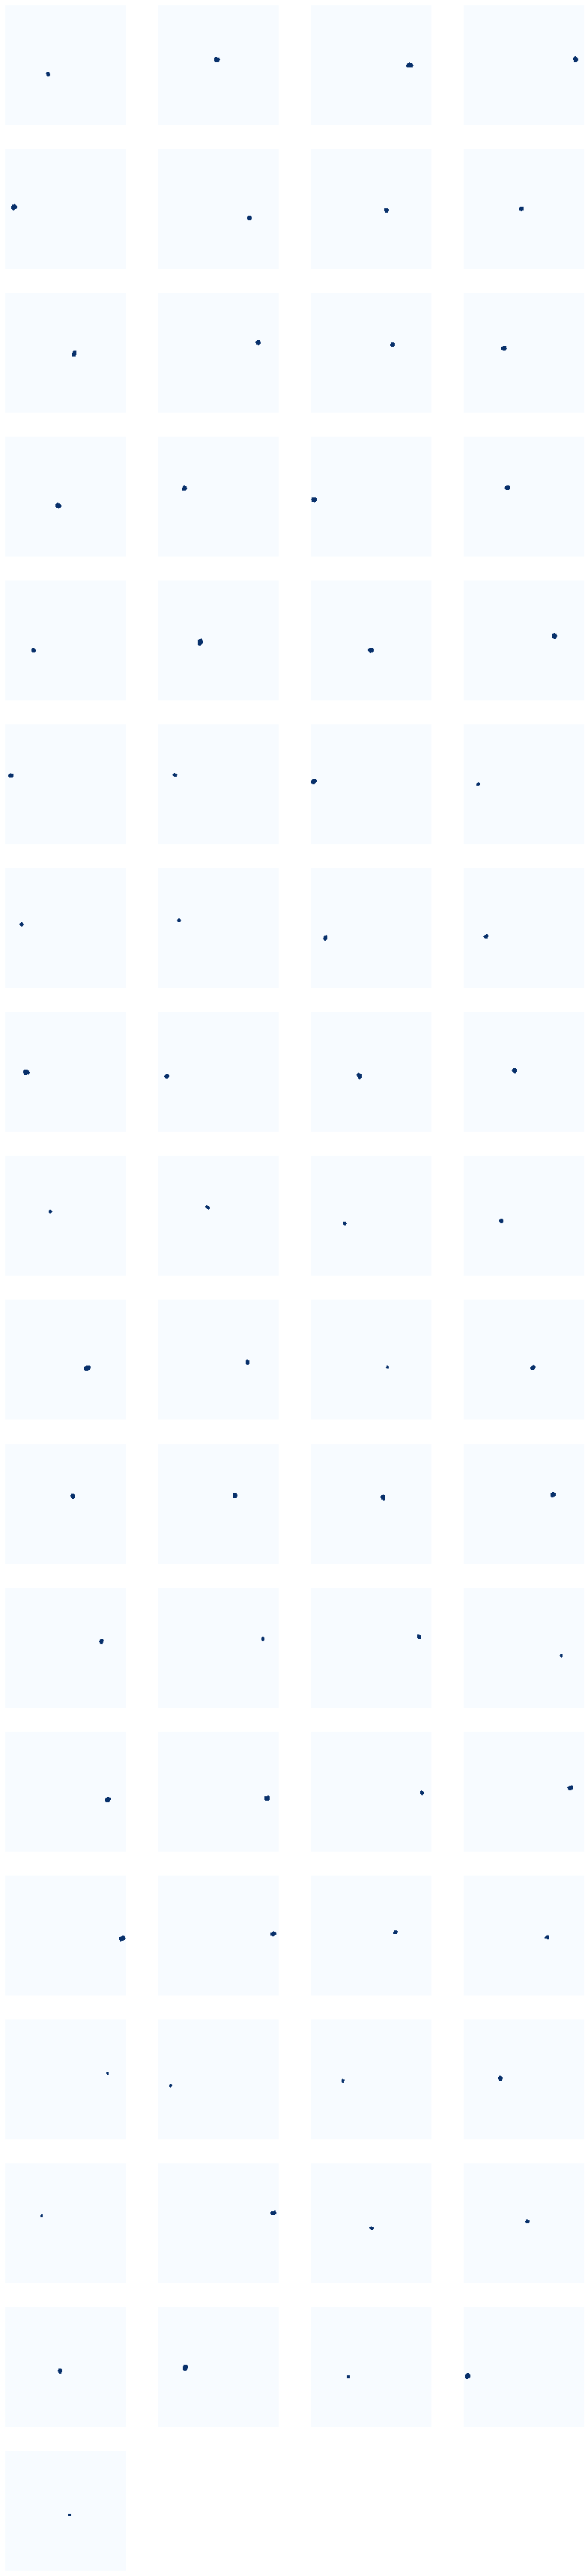

In [87]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [88]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
70 detections: ['particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'particles'
 'particles' 'particles' 'particles' 'particles' 'particles' 'p

In [89]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (70, 28, 28)          min:    0.00000  max:    1.00000  float32
det_masks                shape: (70, 1024, 1024)      min:    0.00000  max:    1.00000  bool


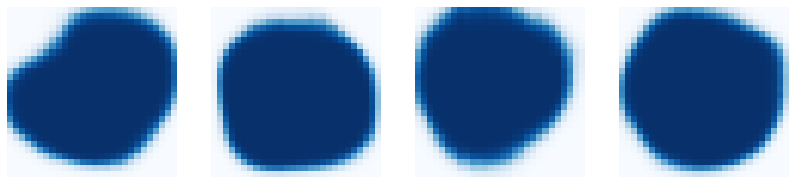

In [90]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

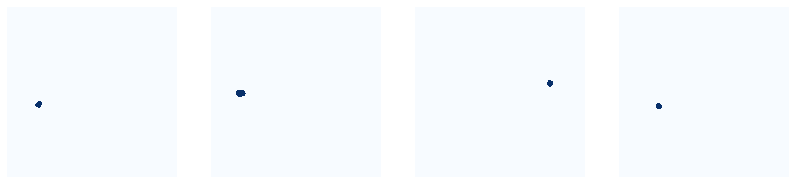

In [91]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [92]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   18.83215  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80073  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   58.07735  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -10.83372  max:   31.86010  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


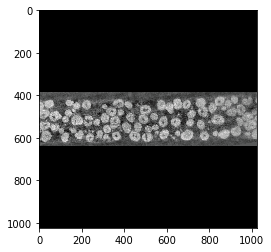

In [93]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [124]:
save_dir

'/home/lijz/LIBNet/data/val_output'

In [134]:
masked_image = Image.fromarray(np.transpose(activations["res2c_out"][0,:,:,:2], [2, 0, 1]).astype(int))
masked_image.save(os.path.join(save_dir, 'img_test2.tif'))

TypeError: Cannot handle this data type: (1, 1, 256), <i8

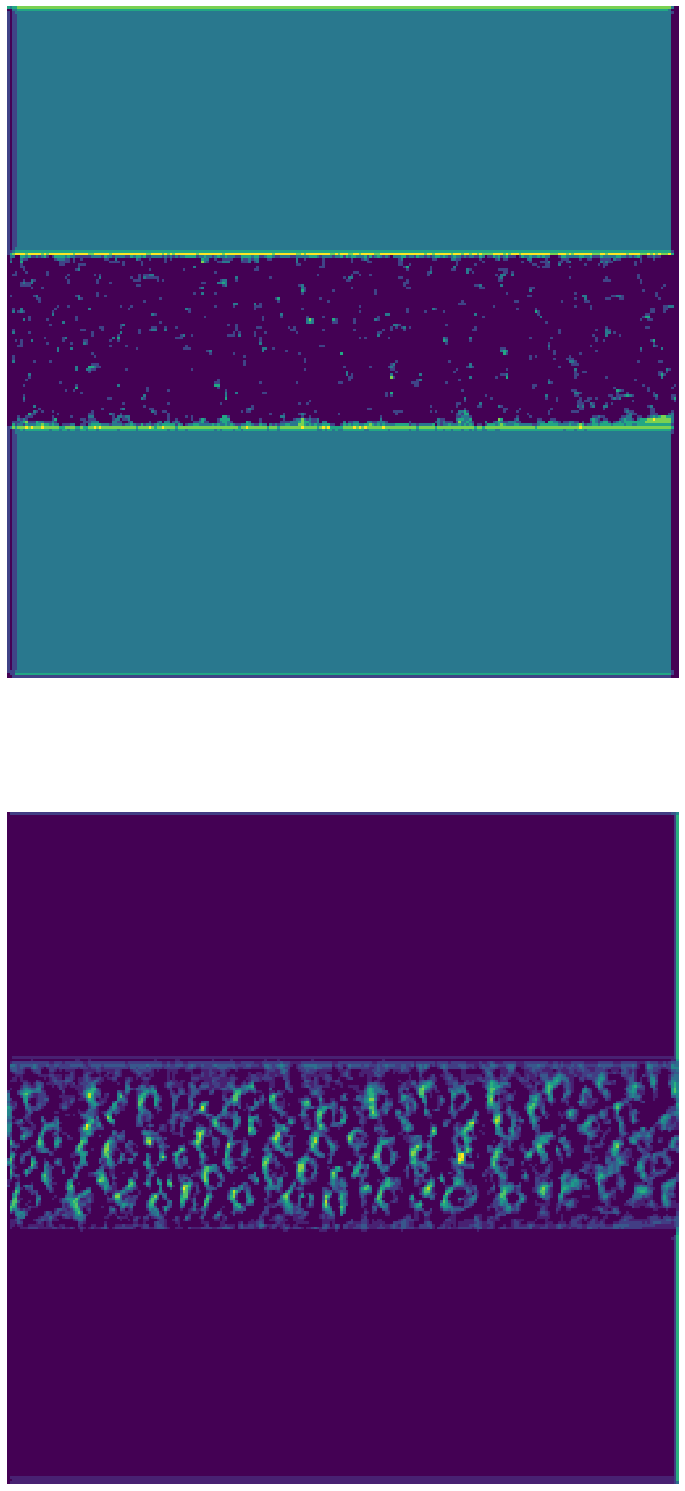

In [132]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:2], [2, 0, 1]), cols=1)